Importing libraries and data files

In [230]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 20)

/kaggle/input/janatahack-crosssell-prediction/test.csv
/kaggle/input/janatahack-crosssell-prediction/sample_submission.csv
/kaggle/input/janatahack-crosssell-prediction/train.csv


In [231]:
train = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/train.csv',index_col=0)
test = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/test.csv',index_col=0)
sample_submission = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/sample_submission.csv',index_col=0)

In [232]:
train[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']] = train[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']].astype('object')
train['Response'] = train['Response'].astype('object')

test[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']] = test[['Driving_License','Previously_Insured','Policy_Sales_Channel','Region_Code']].astype('object')

Treating outliers

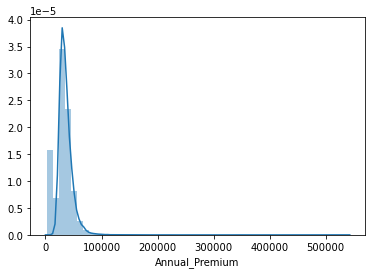

In [233]:
sns.distplot(train['Annual_Premium']);

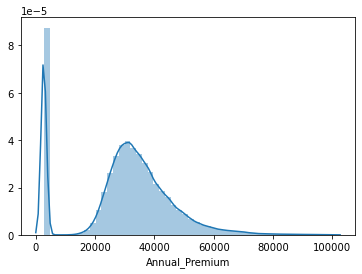

In [234]:
premium_median = train['Annual_Premium'].median()
train['Annual_Premium'] = np.where(train['Annual_Premium']> 100000.000000, premium_median, train['Annual_Premium'])
sns.distplot(train['Annual_Premium']);

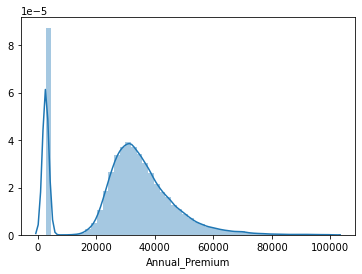

In [235]:
premium_median_test = test['Annual_Premium'].median()
test['Annual_Premium'] = np.where(test['Annual_Premium']> 100000.000000, premium_median_test, test['Annual_Premium'])
sns.distplot(test['Annual_Premium']);

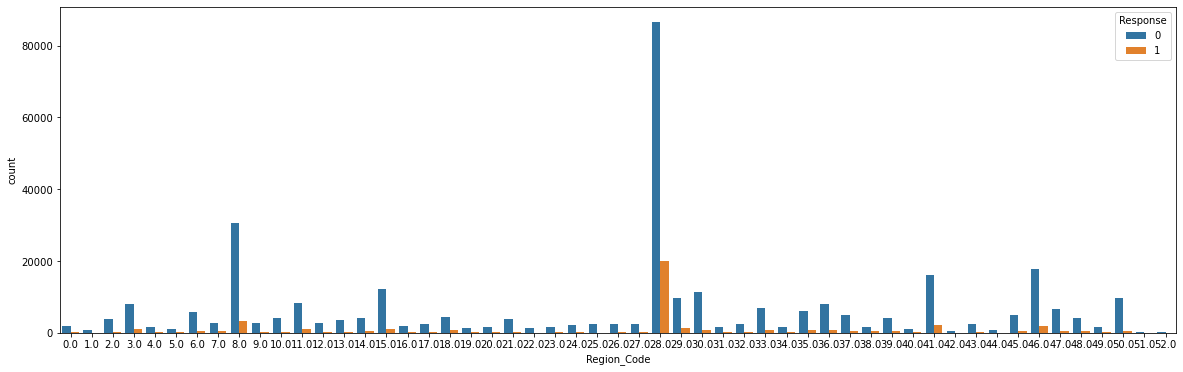

In [236]:
plt.figure(figsize=(20,6))
sns.countplot(x='Region_Code',data=train,hue='Response');

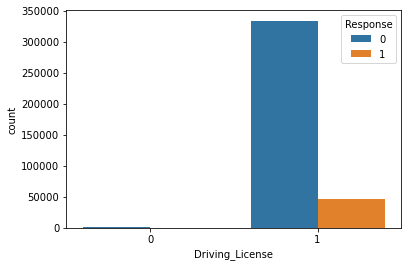

In [237]:
sns.countplot(x='Driving_License',data=train,hue='Response');

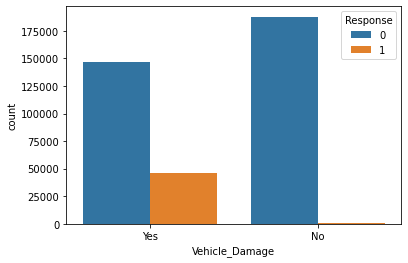

In [238]:
sns.countplot(x='Vehicle_Damage',data=train,hue='Response');

In [239]:
# channel = train['Policy_Sales_Channel'].value_counts()
# pct_80 = train.shape[0]*0.80
# channel.cumsum()[channel.cumsum()<pct_80]

# train[~train['Policy_Sales_Channel'].isin([152,26,124])]['Policy_Sales_Channel'] = 999

# channel.cumsum().iloc[:10]
#every channel other than 152, 26 and 124 has to be coded as 999 i.e. other

In [240]:
train['Vehicle_Age_Damage'] = train['Vehicle_Age'] + '_' + train['Vehicle_Damage']

In [241]:
test['Vehicle_Age_Damage'] = test['Vehicle_Age'] + '_' + test['Vehicle_Damage']

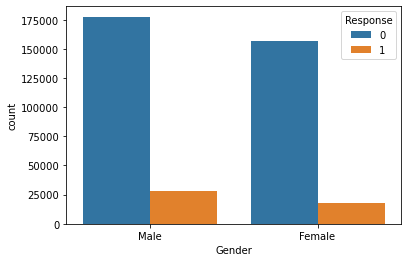

In [242]:
sns.countplot(x='Gender',data=train,hue='Response');

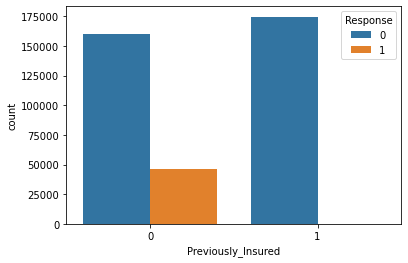

In [243]:
sns.countplot(x='Previously_Insured',data=train,hue='Response');

In [244]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_Damage
id,,,,,,,,,,,,
1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,> 2 Years_Yes
2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,1-2 Year_No
3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,> 2 Years_Yes
4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,< 1 Year_No
5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,< 1 Year_No


Data pre-processing

In [245]:
X = train.drop('Response',axis=1)
y = train['Response'].values

In [246]:
#Scaling numeric variables

sc = StandardScaler()
X[X.select_dtypes(exclude='object').columns.to_list()] = sc.fit_transform(X.select_dtypes(exclude='object'))

In [247]:
test[test.select_dtypes(exclude='object').columns.to_list()] = sc.transform(test.select_dtypes(exclude='object'))

In [248]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_Damage
id,,,,,,,,,,,
1,Male,0.333777,1,28,0,> 2 Years,Yes,0.631395,26,0.748795,> 2 Years_Yes
2,Male,2.396751,1,3,0,1-2 Year,No,0.199979,26,0.342443,1-2 Year_No
3,Male,0.527181,1,28,0,> 2 Years,Yes,0.496695,26,-1.521998,> 2 Years_Yes
4,Male,-1.148985,1,11,1,< 1 Year,No,-0.106651,152,0.581474,< 1 Year_No
5,Female,-0.633242,1,41,1,< 1 Year,No,-0.176683,152,-1.378580,< 1 Year_No


In [249]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_Damage
id,,,,,,,,,,,
381110,Male,-0.891113,1,11,1,< 1 Year,No,0.340293,152,-1.211258,< 1 Year_No
381111,Male,0.075906,1,28,0,1-2 Year,Yes,0.214073,7,-0.518068,1-2 Year_Yes
381112,Male,0.527181,1,28,0,1-2 Year,Yes,0.606201,124,0.533668,1-2 Year_Yes
381113,Male,-0.955581,1,27,1,< 1 Year,Yes,0.438200,152,0.390249,< 1 Year_Yes
381114,Male,-0.762177,1,28,1,< 1 Year,No,1.793998,152,1.704919,< 1 Year_No


In [250]:
#Encoding categorical variables

X = pd.get_dummies(X,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [251]:
le = LabelEncoder()
y = le.fit_transform(y)

Training the model

In [252]:
clf = LGBMClassifier(n_estimators=550,
                     learning_rate=0.03,
                     min_child_samples=40,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)

clf.fit(X, y, verbose=50,eval_metric = 'auc')

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03, min_child_samples=40,
               n_estimators=550, random_state=1, reg_alpha=2, reg_lambda=2)

In [253]:
lgb_pred = clf.predict_proba(X)[:,1]
roc_auc_score(y,lgb_pred)

0.8646864435862901

Pre-processing test data and predicting probabilities

In [254]:
print(test.shape,X.shape)

missing_cols = set(X.columns) - set(test.columns)
for c in missing_cols:
    test[c] = 0

print(test.shape,X.shape)

#keeping the order of columns same for X and test
test = test[X.columns]

(127037, 210) (381109, 220)
(127037, 222) (381109, 220)


In [256]:
test_pred = clf.predict_proba(test)[:,1]

In [215]:
sample_submission['Response'] = test_pred
sample_submission.to_csv('Submission_v5.csv')

In [216]:
sample_submission.head()

,Response
id,
381110,0.000396
381111,0.131089
381112,0.126052
381113,0.003865
381114,0.000316
